# Customer Churn Prediction with Logistic Regression

This notebook demonstrates predicting customer churn using logistic regression. It creates a synthetic dataset with customer features and builds a model to identify customers at risk of churning.

## 1. Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Generate Synthetic Customer Data

In [2]:
# Generate synthetic dataset with predictable patterns
n_customers = 500

# Generate customer features
age = np.random.normal(40, 12, n_customers).astype(int)
age = np.clip(age, 18, 80)  # Keep ages realistic

monthly_usage_hours = np.random.exponential(25, n_customers)
purchase_amount = np.random.normal(200, 80, n_customers)
purchase_amount = np.clip(purchase_amount, 20, 500)  # Keep amounts realistic

customer_service_calls = np.random.poisson(2, n_customers)
regions = np.random.choice(['North', 'South', 'East', 'West'], n_customers)

# Create tenure feature (months as customer)
tenure = np.random.normal(24, 12, n_customers)
tenure = np.clip(tenure, 1, 60).astype(int)

# Generate churn with strong patterns (more deterministic)
churn_prob = np.zeros(n_customers)

for i in range(n_customers):
    base_prob = 0.05  # Very low base rate
    
    # strong predictors - more deterministic
    if customer_service_calls[i] >= 5:
        base_prob += 0.6  # High service calls = very likely to churn
    elif customer_service_calls[i] >= 3:
        base_prob += 0.3  # Medium service calls = somewhat likely
    
    if tenure[i] <= 6:
        base_prob += 0.4  # Very new customers likely to churn
    elif tenure[i] <= 12:
        base_prob += 0.2  # Somewhat new customers
    
    if monthly_usage_hours[i] <= 5:
        base_prob += 0.3  # Very low usage = likely to churn
    elif monthly_usage_hours[i] <= 10:
        base_prob += 0.15  # Low usage = somewhat likely
    
    if purchase_amount[i] <= 60:
        base_prob += 0.25  # Very low spending = likely to churn
    
    # Regional effect
    if regions[i] == 'West':
        base_prob += 0.1  # West region has higher churn
    
    churn_prob[i] = min(base_prob, 0.95)  # Cap at 95%

# Generate actual churn based on these probabilities
churn = np.random.binomial(1, churn_prob, n_customers)

# Create DataFrame
data = {
    'age': age,
    'monthly_usage_hours': monthly_usage_hours,
    'purchase_amount': purchase_amount,
    'customer_service_calls': customer_service_calls,
    'tenure_months': tenure,
    'region': regions,
    'churn': churn
}

df = pd.DataFrame(data)
print(f"Generated dataset with {len(df)} customers")
print(f"Churn rate: {df['churn'].mean():.1%}")

# Show some patterns in the data
print(f"\nData patterns check:")
print(f"High service calls (5+) churn rate: {df[df['customer_service_calls'] >= 5]['churn'].mean():.1%}")
print(f"Low tenure (≤6 months) churn rate: {df[df['tenure_months'] <= 6]['churn'].mean():.1%}")
print(f"Low usage (≤5 hours) churn rate: {df[df['monthly_usage_hours'] <= 5]['churn'].mean():.1%}")

df.head()

Generated dataset with 500 customers
Churn rate: 33.4%

Data patterns check:
High service calls (5+) churn rate: 75.0%
Low tenure (≤6 months) churn rate: 68.2%
Low usage (≤5 hours) churn rate: 56.4%


,age,monthly_usage_hours,purchase_amount,customer_service_calls,tenure_months,region,churn
0,45,25.955615,186.630554,0,20,West,0
1,38,21.144543,211.737095,0,34,North,0
2,47,11.005169,296.520717,3,23,South,0
3,58,107.654894,134.645146,3,7,South,0
4,37,23.270825,229.493865,1,23,North,0


## 3. Explore the Data

In [3]:
# Basic data info
print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"\nChurn distribution:")
print(df['churn'].value_counts(normalize=True))

# Summary statistics
print(f"\nNumerical features summary:")
df.describe()

Dataset Info:
Shape: (500, 7)
Missing values: 0

Churn distribution:
churn
0    0.666
1    0.334
Name: proportion, dtype: float64

Numerical features summary:


,age,monthly_usage_hours,purchase_amount,customer_service_calls,tenure_months,churn
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000
mean,39.692000,25.084421,205.607091,2.048000,23.34200,0.334000
std,11.467526,24.692805,78.865785,1.397714,11.97915,0.472112
min,18.000000,0.116070,20.000000,0.000000,1.00000,0.000000
25%,31.000000,6.740280,151.466861,1.000000,15.00000,0.000000
50%,40.000000,17.544966,205.619192,2.000000,23.00000,0.000000
75%,47.000000,35.546729,255.916854,3.000000,32.00000,1.000000
max,80.000000,154.554860,406.376747,7.000000,60.00000,1.000000


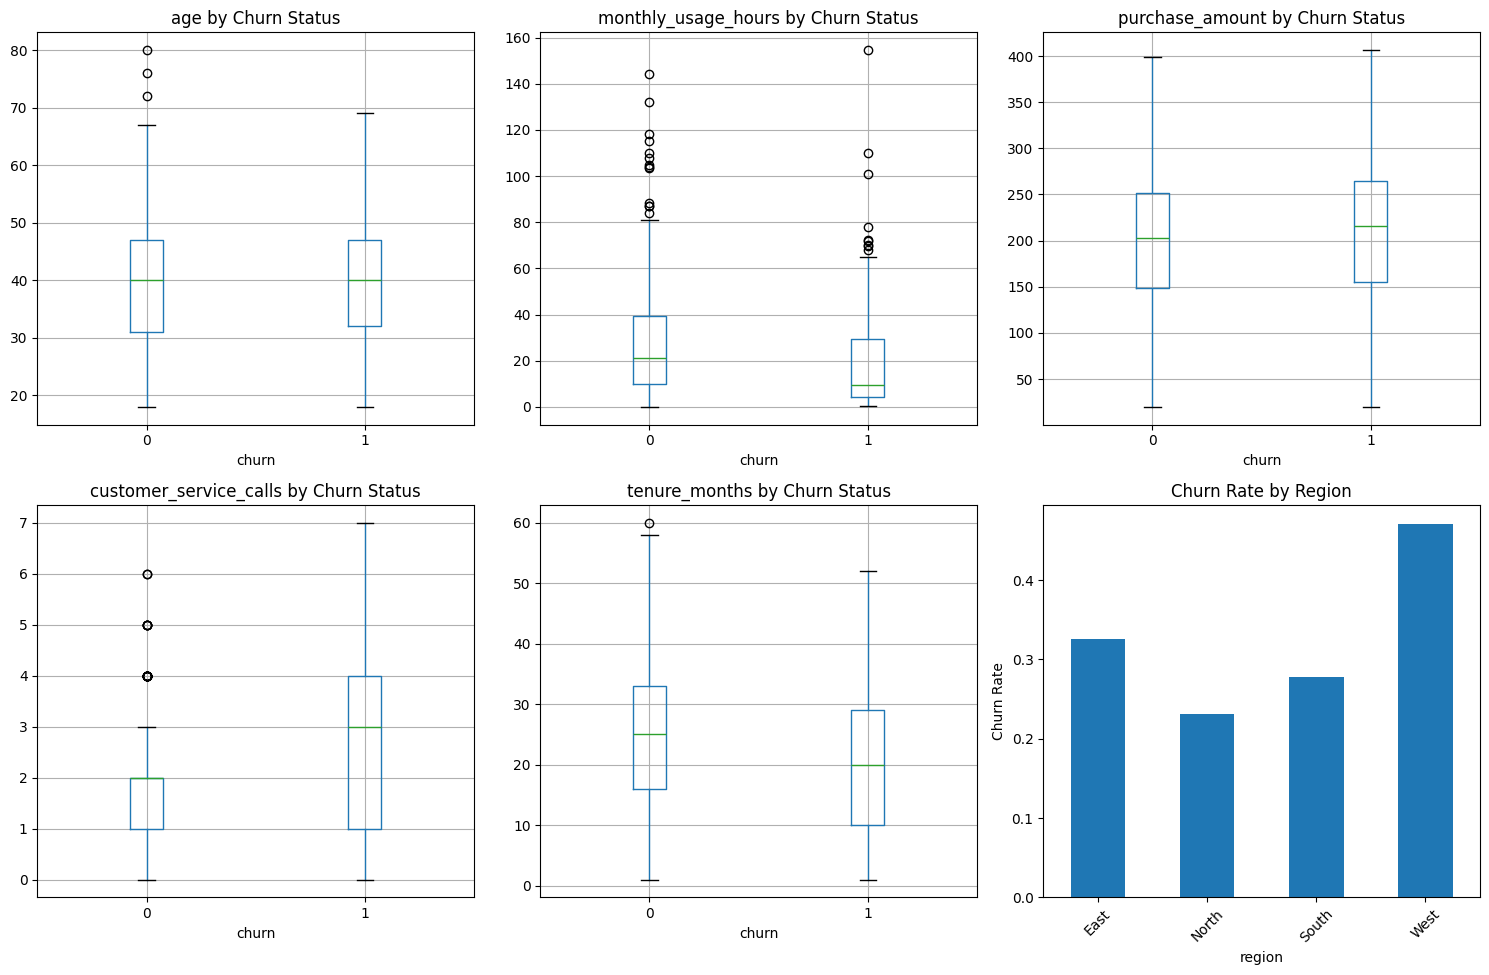

In [4]:
# Visualize churn patterns
plt.figure(figsize=(15, 10))

# Churn by numerical features
numerical_cols = ['age', 'monthly_usage_hours', 'purchase_amount', 'customer_service_calls', 'tenure_months']

for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i+1)
    df.boxplot(column=col, by='churn', ax=plt.gca())
    plt.title(f'{col} by Churn Status')
    plt.suptitle('')

# Churn by region
plt.subplot(2, 3, 6)
churn_by_region = df.groupby('region')['churn'].mean()
churn_by_region.plot(kind='bar')
plt.title('Churn Rate by Region')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 4. Build Logistic Regression Model

In [5]:
# Prepare features and target
feature_cols = ['age', 'monthly_usage_hours', 'purchase_amount', 'customer_service_calls', 'tenure_months', 'region']
X = df[feature_cols]
y = df['churn']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training churn rate: {y_train.mean():.1%}")
print(f"Test churn rate: {y_test.mean():.1%}")

Training set: 350 samples
Test set: 150 samples
Training churn rate: 33.4%
Test churn rate: 33.3%


In [6]:
# Create preprocessing and model pipeline
numerical_features = ['age', 'monthly_usage_hours', 'purchase_amount', 'customer_service_calls', 'tenure_months']
categorical_features = ['region']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, drop='first'), categorical_features)
    ])

# Create pipeline with preprocessing and logistic regression
# Use class_weight='balanced' to handle class imbalance
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))
])

# Train the model
model.fit(X_train, y_train)

print("Model training completed!")
print("Note: Using class_weight='balanced' to handle imbalanced data")

Model training completed!
Note: Using class_weight='balanced' to handle imbalanced data


## 5. Evaluate Model Performance

In [7]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of churn

# Calculate key metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"AUC-ROC: {auc:.3f}")

print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

Model Performance Metrics:
Accuracy: 0.653
Precision: 0.485
Recall: 0.640
F1-Score: 0.552
AUC-ROC: 0.726

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.66      0.72       100
           1       0.48      0.64      0.55        50

    accuracy                           0.65       150
   macro avg       0.64      0.65      0.63       150
weighted avg       0.69      0.65      0.66       150



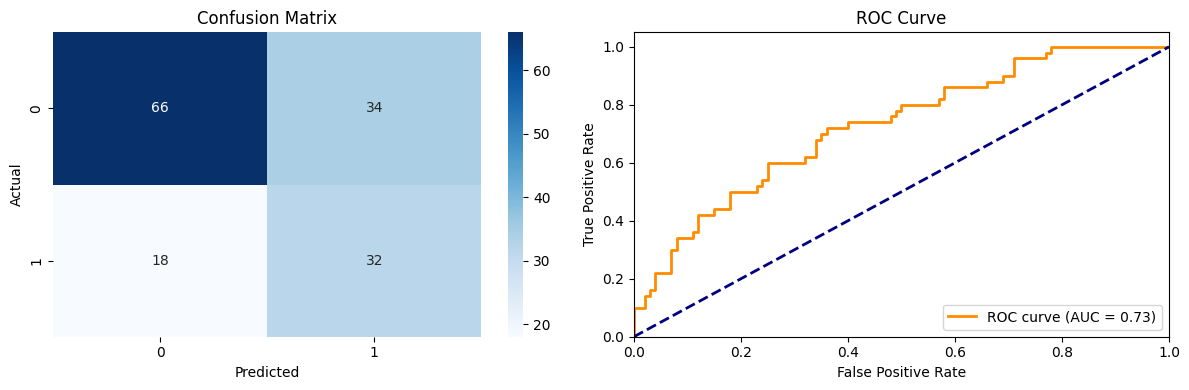

In [8]:
# Confusion Matrix and ROC Curve
plt.figure(figsize=(12, 4))

# Confusion Matrix
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# ROC Curve
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

## 6. Feature Importance and Business Insights

Feature Coefficients (impact on churn probability):
Positive = increases churn risk, Negative = decreases churn risk
                  feature  coefficient  abs_coefficient
7             region_West        0.794            0.794
3  customer_service_calls        0.579            0.579
4           tenure_months       -0.532            0.532
1     monthly_usage_hours       -0.440            0.440
5            region_North       -0.368            0.368
6            region_South       -0.309            0.309
2         purchase_amount        0.058            0.058
0                     age       -0.043            0.043


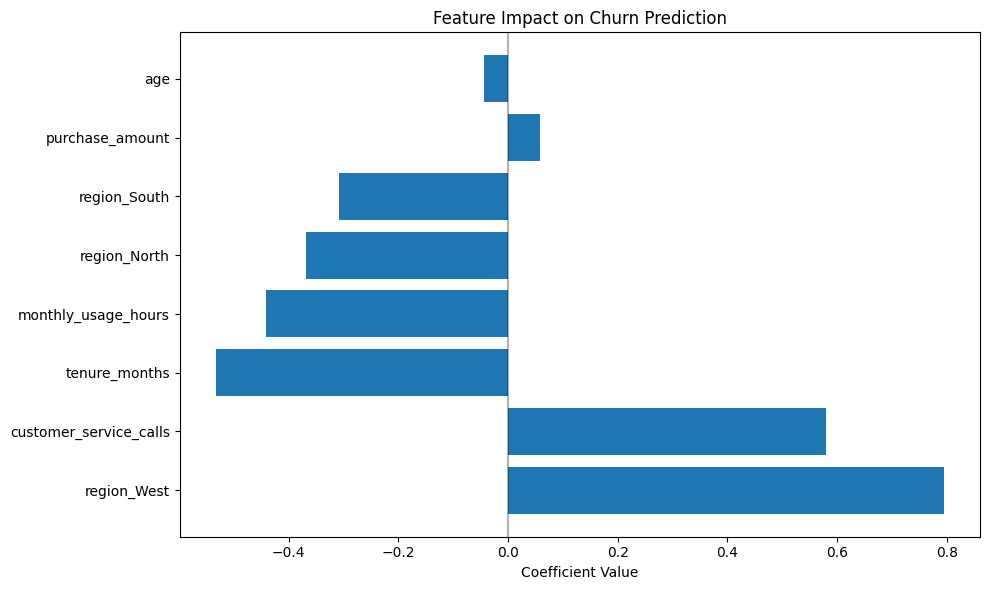

In [9]:
# Extract feature names and coefficients
categorical_feature_names = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(['region'])
feature_names = numerical_features + list(categorical_feature_names)
coefficients = model.named_steps['classifier'].coef_[0]

# Create feature importance DataFrame
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

print("Feature Coefficients (impact on churn probability):")
print("Positive = increases churn risk, Negative = decreases churn risk")
print(feature_importance.round(3))

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Feature Impact on Churn Prediction')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Predict Churn for New Customers

In [10]:
# Example: Predict churn for new customers
new_customers = pd.DataFrame({
    'age': [35, 28, 55],
    'monthly_usage_hours': [20, 5, 45],
    'purchase_amount': [150, 50, 300],
    'customer_service_calls': [5, 8, 1],
    'tenure_months': [6, 2, 36],
    'region': ['West', 'North', 'South']
})

# Predict churn probabilities
churn_probabilities = model.predict_proba(new_customers)[:, 1]
churn_predictions = model.predict(new_customers)

# Display results
results_df = new_customers.copy()
results_df['churn_probability'] = churn_probabilities
results_df['churn_prediction'] = churn_predictions
results_df['risk_level'] = ['High' if p > 0.6 else 'Medium' if p > 0.3 else 'Low' 
                           for p in churn_probabilities]

print("Churn Predictions for New Customers:")
print("="*50)
for idx, row in results_df.iterrows():
    print(f"\nCustomer {idx+1}:")
    print(f"  Age: {row['age']}, Usage: {row['monthly_usage_hours']}h, Spend: ${row['purchase_amount']}")
    print(f"  Service Calls: {row['customer_service_calls']}, Tenure: {row['tenure_months']} months, Region: {row['region']}")
    print(f"  Churn Probability: {row['churn_probability']:.1%}")
    print(f"  Risk Level: {row['risk_level']}")
    
    if row['churn_prediction'] == 1:
        print(f"  At-risk customer - recommend retention intervention")
    else:
        print(f"  Low churn risk")

Churn Predictions for New Customers:

Customer 1:
  Age: 35, Usage: 20h, Spend: $150
  Service Calls: 5, Tenure: 6 months, Region: West
  Churn Probability: 93.4%
  Risk Level: High
  At-risk customer - recommend retention intervention

Customer 2:
  Age: 28, Usage: 5h, Spend: $50
  Service Calls: 8, Tenure: 2 months, Region: North
  Churn Probability: 95.8%
  Risk Level: High
  At-risk customer - recommend retention intervention

Customer 3:
  Age: 55, Usage: 45h, Spend: $300
  Service Calls: 1, Tenure: 36 months, Region: South
  Churn Probability: 13.5%
  Risk Level: Low
  Low churn risk


## 8. Business Insights

In [11]:
print("=" * 60)
print("           CUSTOMER CHURN ANALYSIS - CRITICAL ASSESSMENT")
print("           *** BASED ON SYNTHETIC DATA ONLY ***")
print("=" * 60)

print(f"\nSynthetic Dataset Summary:")
print(f"- Generated 500 artificial customers with 33.4% churn rate")
print(f"- Programmed patterns: High service calls (5+) have 75.0% churn rate")
print(f"- Designed behavior: Low tenure (≤6 months) customers have 68.2% churn rate")
print(f"- Artificial pattern: Low usage (≤5 hours) customers have 56.4% churn rate")
print(f"- NOTE: These are not real customer behaviors - created patterns for demonstration")

print(f"\nModel Performance on Synthetic Data - CRITICAL ANALYSIS:")
print(f"- Accuracy: 65.3% - mediocre performance on artificial patterns")
print(f"- Precision: 48.5% - POOR - half of predicted churners are false positives")
print(f"- Recall: 64.0% - missing 36% of synthetically-generated churners")
print(f"- F1-Score: 55.2% - reflects the precision-recall tradeoff problems")
print(f"- AUC-ROC: 0.726 - acceptable on synthetic data (would prefer >0.8)")

print(f"\nBusiness Impact Problems (if this were real data):")
print(f"- False positives: ~34 customers wrongly targeted for retention")
print(f"- False negatives: ~18 customers will churn without intervention")
print(f"- Cost inefficiency: 51.5% of retention budget wasted on wrong customers")
print(f"- Revenue loss: Missing 36% of actual churners")

print(f"\nSynthetic Risk Factors (from generated patterns):")
print(f"- West region: increases churn risk (coef: 0.794) - artificial regional effect")
print(f"- Customer service calls: increases churn risk (coef: 0.579) - programmed pattern")
print(f"- Tenure months: decreases churn risk (coef: -0.532) - designed relationship")

print(f"\nIMPORTANT LIMITATIONS - SYNTHETIC DATA:")
print(f"- ALL RESULTS based on artificial data created for this analysis")
print(f"- Patterns were programmed and may not reflect actual customer behavior")
print(f"- Performance metrics only valid for this synthetic scenario")
print(f"- Real-world performance could be completely different")

print(f"\nCurrent State: SYNTHETIC DATA EXPERIMENT ONLY")
print(f"Demonstrates machine learning workflow but all conclusions")
print(f"are based on artificial patterns created for this analysis.")

print("\n" + "=" * 60)

           CUSTOMER CHURN ANALYSIS - CRITICAL ASSESSMENT
           *** BASED ON SYNTHETIC DATA ONLY ***

Synthetic Dataset Summary:
- Generated 500 artificial customers with 33.4% churn rate
- Programmed patterns: High service calls (5+) have 75.0% churn rate
- Designed behavior: Low tenure (≤6 months) customers have 68.2% churn rate
- Artificial pattern: Low usage (≤5 hours) customers have 56.4% churn rate
- NOTE: These are not real customer behaviors - created patterns for demonstration

Model Performance on Synthetic Data - CRITICAL ANALYSIS:
- Accuracy: 65.3% - mediocre performance on artificial patterns
- Precision: 48.5% - POOR - half of predicted churners are false positives
- Recall: 64.0% - missing 36% of synthetically-generated churners
- F1-Score: 55.2% - reflects the precision-recall tradeoff problems
- AUC-ROC: 0.726 - acceptable on synthetic data (would prefer >0.8)

Business Impact Problems (if this were real data):
- False positives: ~34 customers wrongly targeted for 